Basic analysis to iHMP_IBDMDB_2019. The overlap (21 metabolites) with OSA. 

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessors import MetabolitePreprocessor


Metabolite mapped to HMDB - v. Taxa mapped using GTDB - v.
This research data is HMP2 cohort - longitudinal samples from IBD patient and control.
The metabolom is untargeted. Microbiome is shotgun. 
There are 382 samples for 105 patient. For control we have 104 samples for 26 subjects.
We will take only control and all samples (ignoring longitudinal). 


In [5]:
human_db_path = '/home/noa/lab_code/microbiome-metabolome-curated-data/data/processed_data'
dataset = 'iHMP_IBDMDB_2019'

metadata = pd.read_csv(f'{human_db_path}/{dataset}/metadata.tsv' ,sep='\t')
metabolite = pd.read_csv(f'{human_db_path}/{dataset}/mtb.tsv' ,sep='\t')
metabolite_to_hmdb = pd.read_csv(f'{human_db_path}/{dataset}/mtb.map.tsv' ,sep='\t')
taxa = pd.read_csv(f'{human_db_path}/{dataset}/genera.tsv' ,sep='\t')

In [6]:
metabolite_to_hmdb = metabolite_to_hmdb.set_index('Compound')['HMDB']

Metadata overview: Study.Group:
CD - Crohn's disease
UC - ulcreative colitis. 
nonIBD - control 

In [7]:
# Filter to control samples only:
control_samples_ids = metadata[metadata['Study.Group'] == 'nonIBD'].Sample.unique()
taxa = taxa[taxa.Sample.isin(control_samples_ids)]
metabolite = metabolite[metabolite.Sample.isin(control_samples_ids)]


Taxa is in genus level in relative abundance. 
No need to normalize, but do need to filter rare taxa. 

In [8]:
# Filter rare taxa (taxa have non-zero values in >10% of the samples)")
# Filter rare taxa according to the following criteria: we want that the at least 10% of the samples will have relative-abundance larger than 0.001.

taxa = taxa.set_index('Sample')
verbose=False
percentage=10
abundance_threshold=0.001
min_number_of_samples = int((taxa.shape[0] / 100) * percentage)
print(
    f"The number of genus/features that have relative abundance values larger then {abundance_threshold} on > {percentage} % samples are: "
    f"{(((taxa > abundance_threshold).sum(axis=0)) >= min_number_of_samples).sum()}"
    f" out of {taxa.shape[1]} genus/features before-filtering.")

non_rare_columns = taxa.columns[
    ((taxa > abundance_threshold).sum(axis=0)) >= min_number_of_samples]
taxa = taxa[non_rare_columns]

The number of genus/features that have relative abundance values larger then 0.001 on > 10 % samples are: 107 out of 9694 genus/features before-filtering.


In [9]:
# taxa_mean_abundance_across_samples = taxa.mean()

In [10]:
# taxa_mean_abundance_across_samples.plot.hist(bins=100)

In [11]:
# pd.cut(taxa_mean_abundance_across_samples, bins=20, retbins=True)
# taxa_mean_abundance_across_samples.describe()

In [12]:
# print(f"{np.count_nonzero(taxa_mean_abundance_across_samples < 0.01)} out of {taxa_mean_abundance_across_samples.shape[0]} samples have mean-relative abundance below 0.01%. \n"
#       f" AKA {round((np.count_nonzero(taxa_mean_abundance_across_samples < 0.01)) / taxa_mean_abundance_across_samples.shape[0] * 100, 2)} % consider rare. Filtering using this threshold will leave us with: {( taxa_mean_abundance_across_samples.shape[0] - (np.count_nonzero(taxa_mean_abundance_across_samples < 0.01)))} genus.")

In [13]:
# So maybe selecting the mean in such diverse dataset is too much? maybe we should take other quantile? 
# Maybe we can say that we want that in 10% of the samples it will have relative-abundance above x? 
# Or that in the median? 
# taxa_q10_abundance_across_samples = taxa.quantile(q=0.9)


In [14]:
# taxa_q10_abundance_across_samples.plot.hist(bins=100)


In [15]:
# taxa_q10_abundance_across_samples.describe()

In [16]:
# taxa_q10_abundance_across_samples.sort_values()


In [17]:
# print(f"{np.count_nonzero(taxa_q10_abundance_across_samples < 0.01)} out of {taxa_q10_abundance_across_samples.shape[0]} samples have quantile 90% relative abundance below 0.01%. \n"
#       f" AKA {round((np.count_nonzero(taxa_q10_abundance_across_samples < 0.01)) / taxa_q10_abundance_across_samples.shape[0] * 100, 2)} % consider rare. Filtering using this threshold will leave us with: {( taxa_q10_abundance_across_samples.shape[0] - (np.count_nonzero(taxa_q10_abundance_across_samples < 0.01)))} genus.")

In [18]:
# print(f"{np.count_nonzero(taxa_q10_abundance_across_samples < 0.001)} out of {taxa_q10_abundance_across_samples.shape[0]} samples have quantile 90% relative abundance below 0.001%. \n"
#       f" AKA {round((np.count_nonzero(taxa_q10_abundance_across_samples < 0.001)) / taxa_q10_abundance_across_samples.shape[0] * 100, 2)} % consider rare. Filtering using this threshold will leave us with: {( taxa_q10_abundance_across_samples.shape[0] - (np.count_nonzero(taxa_q10_abundance_across_samples < 0.001)))} genus.")

Filter rare taxa according to the following criteria: we want that the at least 10% of the samples will have relative-abundance larger than 0.001.

In [19]:
metabolite = metabolite.set_index('Sample')

In [20]:
# metabolite.columns.isin(metabolite_to_hmdb.index).all()
metabolite = metabolite[metabolite.columns.intersection(metabolite_to_hmdb.dropna().index)].rename(columns=metabolite_to_hmdb.dropna())

Map compound to HMDB (article metabolite name in the original data). As it can be many to one, we will sum according to HMDB.

In [21]:
metabolite = metabolite.groupby(by=metabolite.columns, axis=1).sum()

In [22]:
metabolite.shape

(104, 454)

Filter rare metabolite

In [23]:
percentage = 85
min_number_of_samples = int((metabolite.shape[0] / 100) * percentage)
min_number_of_samples

88

In [24]:
metabolite.shape

(104, 454)

In [25]:
metabolite = metabolite.fillna(0)

In [26]:
(metabolite.round(decimals=8) == 0).sum(axis=0)

HMDB0000014    16
HMDB0000017     0
HMDB0000019     2
HMDB0000020     0
HMDB0000026     0
               ..
HMDB0042466    24
HMDB0043058     0
HMDB0059655     0
HMDB0059824     0
HMDB0060038     0
Length: 454, dtype: int64

In [27]:
non_rare_columns = metabolite.columns[((metabolite.shape[0] - (
            metabolite.round(decimals=8) == 0).sum(axis=0)) >= min_number_of_samples)]
print(f"There are {len(non_rare_columns)} metabolite with sufficient number of samples "
      f"(>{percentage}%) out of {metabolite.shape[1]} metabolites.")
metabolite= metabolite[non_rare_columns]

There are 375 metabolite with sufficient number of samples (>85%) out of 454 metabolites.


Pre-processing metabolite data:

In [28]:
# hmdb_metadata = pd.read_xml('/home/noa/lab_code/H2Mtranslation/data/feces_metabolites.xml')
# map_hmdb_id_to_name = hmdb_metadata.set_index('accession', drop=True)['name']
# map_hmdb_id_to_name.to_pickle('/home/noa/lab_code/H2Mtranslation/data/map_hmdb_id_to_name.pkl')
# hmdb_metadata.set_index('accession', drop=True)[['name', 'description']].to_pickle('/home/noa/lab_code/H2Mtranslation/data/hmdb_name_and_description.pkl')


In [29]:
map_hmdb_id_to_name = pd.read_pickle('/home/noa/lab_code/H2Mtranslation/data/map_hmdb_id_to_name.pkl')

In [30]:
hmdb_metadata = pd.read_pickle('/home/noa/lab_code/H2Mtranslation/data/hmdb_name_and_description.pkl')


In [31]:
min_value_per_metabolite = metabolite.replace(to_replace=0, value=np.nan).min(axis=0) / 2
metabolite.replace(to_replace=np.nan, value=0, inplace=True)
metabolite.replace(to_replace=0, value=min_value_per_metabolite, inplace=True)
metabolite = metabolite.apply(lambda x: np.log(x + 1))

In [32]:
metabolite = metabolite.rename(columns=map_hmdb_id_to_name)

In [33]:
metabolite.head()

,Deoxycytidine,4-Pyridoxic acid,alpha-Ketoisovaleric acid,p-Hydroxyphenylacetic acid,Ureidopropionic acid,Biotin,Adenine,Taurocholic acid,Butyric acid,Betaine,...,N-Acetylhistidine,HMDB0035665,17-Methyloctadecanoic acid,HMDB0037942,TG(14:0/14:0/16:0),HMDB0042093,HMDB0043058,2-Hydroxyglutarate,HMDB0059824,10Z-Heptadecenoic acid
Sample,,,,,,,,,,,,,,,,,,,,,
HSM5MD5D,12.818366,14.149857,10.236991,10.802408,9.801067,18.017231,14.302072,13.069583,15.220003,11.722051,...,10.983070,8.921725,7.474772,11.372916,8.328209,9.034677,9.106978,11.996672,8.412055,12.759515
MSM6J2K6,15.510480,15.616391,9.592059,11.748164,9.639001,17.552187,15.118838,14.322898,15.558922,13.311884,...,11.961903,8.158516,10.554145,12.910531,7.724005,8.360773,10.696412,12.976577,10.601199,15.023866
HSM5MD6K,15.267840,14.491845,7.985825,11.977470,9.835423,17.051244,14.985529,13.674023,16.236450,13.114035,...,12.452268,10.565273,7.426549,14.486872,6.380123,7.874739,10.091460,11.489984,9.605822,12.312858
MSM6J2HT,16.727060,15.203554,9.617271,13.011155,10.635158,16.334514,14.196841,15.915374,15.786928,13.736330,...,10.711658,7.231287,10.719251,12.291635,2.140066,8.196437,10.134004,12.532018,10.553153,13.993887
MSM6J2JR,14.153341,12.077506,7.546974,11.778416,8.489205,18.341299,13.402568,11.597285,15.355539,13.193619,...,10.173706,8.054205,10.098520,12.539816,15.878592,7.670429,11.928935,11.867189,9.873131,13.960778


Correlation test:
For each metabolite independently, and for each taxa independently, (aka for each (metabolite, genus) tuple) calculate correlation across samples. 

In [34]:
# Do we have 'Unknown' in our taxa? no. They drop unknown - is it problematic? As in mice we do have unknown... But it's really different %. 

In [35]:
metabolome_bacteria_corr_coefficient = pd.DataFrame(index=taxa.columns, columns=metabolite.columns)
metabolome_bacteria_p_values = pd.DataFrame(index=taxa.columns, columns=metabolite.columns)

for metabolome in metabolite.columns:
    for bacteria in taxa.columns:
        coefficient, p  = stats.pearsonr(metabolite[metabolome], taxa[bacteria])
        metabolome_bacteria_corr_coefficient.loc[bacteria, metabolome] = coefficient
        metabolome_bacteria_p_values.loc[bacteria, metabolome] = p
        

In [36]:
# With multi-comparison correction (FDR)
# what to do with nans?
p_values = metabolome_bacteria_p_values.stack()
_, p_values_corrected = fdrcorrection(p_values)
metabolome_bacteria_p_values_fdr_correction = pd.Series(p_values_corrected, index=p_values.index).unstack()

In [37]:
metabolome_bacteria_p_values_fdr_correction

,Deoxycytidine,4-Pyridoxic acid,alpha-Ketoisovaleric acid,p-Hydroxyphenylacetic acid,Ureidopropionic acid,Biotin,Adenine,Taurocholic acid,Butyric acid,Betaine,...,N-Acetylhistidine,HMDB0035665,17-Methyloctadecanoic acid,HMDB0037942,TG(14:0/14:0/16:0),HMDB0042093,HMDB0043058,2-Hydroxyglutarate,HMDB0059824,10Z-Heptadecenoic acid
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella,0.961348,0.628198,0.830815,0.119585,0.626491,0.84043,0.714213,0.823557,0.553529,0.614162,...,0.606425,0.373164,0.988253,0.421865,0.762604,0.982125,0.539798,0.691973,0.745922,0.914238
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Acutalibacteraceae;g__CAG-177,0.948426,0.909745,0.89562,0.589998,0.673936,0.692918,0.77321,0.645577,0.885137,0.690572,...,0.934485,0.919154,0.90303,0.816766,0.924347,0.641599,0.889326,0.813888,0.606008,0.969355
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__Faecousia,0.221822,0.548235,0.855856,0.044336,0.316044,0.36032,0.542672,0.397527,0.407414,0.23569,...,0.599892,0.883252,0.948801,0.266415,0.843295,0.439252,0.178243,0.501634,0.965313,0.899909
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Alloprevotella,0.890623,0.702487,0.745272,0.407664,0.864904,0.687286,0.885257,0.516275,0.934985,0.919008,...,0.268778,0.658043,0.419118,0.818769,0.420019,0.926171,0.005507,0.128425,0.420794,0.06462
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Anaerotignaceae;g__Anaerotignum,0.77871,0.916191,0.716805,0.420019,0.592956,0.778231,0.99629,0.244094,0.633848,0.654577,...,0.907762,0.97768,0.675636,0.960664,0.988264,0.934658,0.652426,0.84478,0.895794,0.885259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Eubacterium_I,0.854036,0.880056,0.795692,0.836611,0.966218,0.81116,0.903514,0.329019,0.901655,0.854481,...,0.993081,0.91574,0.965638,0.97289,0.97822,0.905975,0.802611,0.7676,0.972847,0.732932
d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Veillonellales;f__Megasphaeraceae;g__Megasphaera,0.646611,0.511542,0.887379,0.45044,0.223604,0.792869,0.868461,0.720525,0.587251,0.550595,...,0.68539,0.224399,0.869651,0.03332,0.641276,0.647895,0.198848,0.052125,0.981588,0.877811
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Roseburia,0.774852,0.821383,0.993492,0.261883,0.718854,0.922397,0.981256,0.869497,0.980435,0.972291,...,0.814232,0.779126,0.842037,0.753776,0.764157,0.914361,0.897061,0.452479,0.975635,0.925482
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__CAG-103,0.945579,0.746828,0.790865,0.081095,0.950838,0.172247,0.956391,0.089173,0.992004,0.863564,...,0.942204,0.893836,0.9768,0.832375,0.902995,0.790256,0.637406,0.922043,0.29014,0.512948


In [38]:
metabolome_bacteria_corr_coefficient = metabolome_bacteria_corr_coefficient.T.stack()
metabolome_bacteria_p_values_fdr_correction = metabolome_bacteria_p_values_fdr_correction.T.stack()

In [39]:
metabolome_bacteria_significant_corr = metabolome_bacteria_corr_coefficient[metabolome_bacteria_p_values_fdr_correction < 0.05]

In [40]:
print(f"There are {metabolome_bacteria_significant_corr.shape[0]} significant couples out of {metabolome_bacteria_corr_coefficient.shape[0]} "
      f" ({taxa.shape[1]} genus, {metabolite.shape[1]} metabolome) "
      f"after FDR correction (aka {round(100 * metabolome_bacteria_significant_corr.shape[0]/ metabolome_bacteria_corr_coefficient.shape[0] ,2)} %.)")

There are 901 significant couples out of 40125  (107 genus, 375 metabolome) after FDR correction (aka 2.25 %.)


In [41]:
metabolome_bacteria_significant_corr.sort_values(ascending=False)


Sorbitol                 d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Coprococcus                         0.531131
Azelaic acid             d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis                    0.52874
Mandelic acid            d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;g__Catenibacterium                     0.514211
                         d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A     0.51216
Azelaic acid             d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__Faecousia                         0.467607
                                                                                                                                                 ...   
3-Methylhistidine        d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__

In [42]:
metabolome_bacteria_significant_corr.to_pickle(f'{dataset}/metabolome_bacteria_significant_corr_draft1.pkl')
metabolome_bacteria_corr_coefficient.to_pickle(f'{dataset}/metabolome_bacteria_corr_coefficient_draft1.pkl')
metabolome_bacteria_p_values_fdr_correction.to_pickle(f'{dataset}/metabolome_bacteria_p_values_fdr_correction_draft1.pkl')

In [43]:
taxa_rename_to_genus = pd.Series(metabolome_bacteria_significant_corr.index.get_level_values(1), index=metabolome_bacteria_significant_corr.index.get_level_values(1)).str.extract('.*g__(.*)').squeeze()

In [44]:
taxa_rename_to_genus.head()

d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes_A                       Alistipes_A
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Coprococcus                     Coprococcus
d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia      Akkermansia
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__Faecousia                       Faecousia
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Acutalibacteraceae;g__Clostridium_A             Clostridium_A
Name: 0, dtype: object

In [45]:
metabolome_bacteria_significant_corr = metabolome_bacteria_significant_corr.rename(taxa_rename_to_genus.to_dict(), axis=0, level=1)

<Axes: title={'center': 'Sorbitol'}>

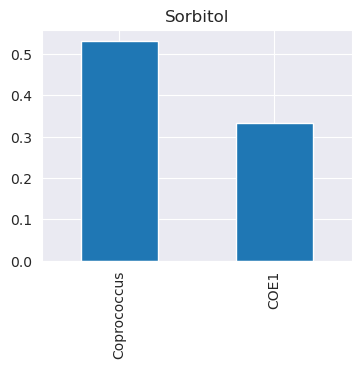

In [46]:
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

top_metabolite = metabolome_bacteria_significant_corr.sort_values(ascending=False).index[0][0]
idx = pd.IndexSlice
metabolome_bacteria_significant_corr.loc[idx[top_metabolite, :]].sort_values(ascending=False).plot.bar(figsize=(4,3), title=top_metabolite)

<Axes: title={'center': '2-Aminoisobutyric acid'}>

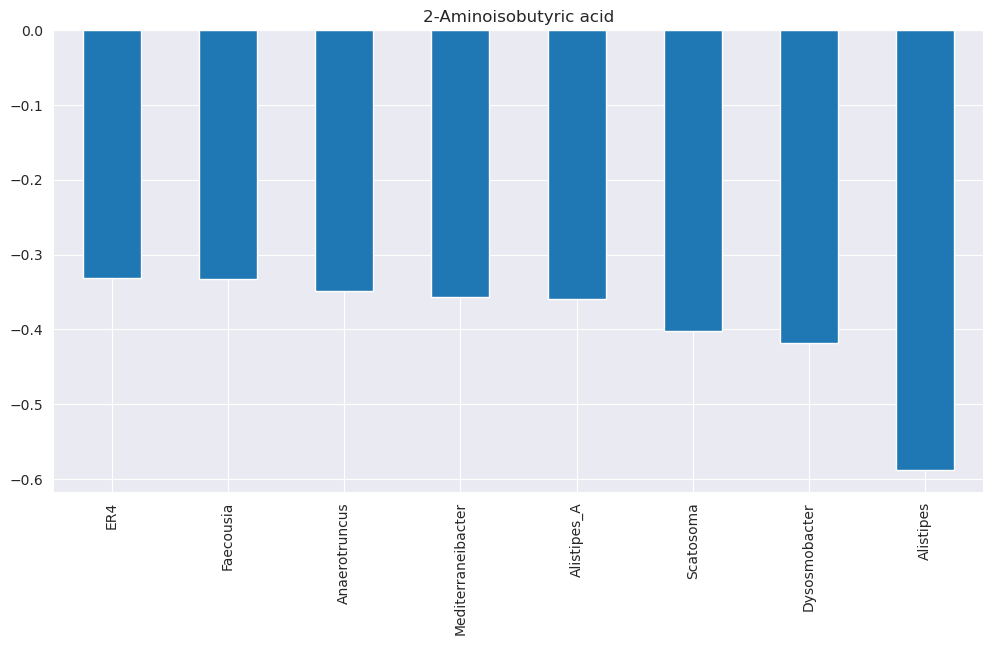

In [47]:
bottom_metabolite = metabolome_bacteria_significant_corr.sort_values(ascending=False).index[-1][0]
metabolome_bacteria_significant_corr.loc[idx[bottom_metabolite, :]].sort_values(ascending=False).plot.bar(figsize=(12,6), title=bottom_metabolite)

In [48]:
# How many bacteria are significantly correlated with metabolites?
print(f"We have {len(metabolome_bacteria_significant_corr.index.get_level_values(1).unique())} microbes with significant correlation to metabolite out of "
      f"{taxa.shape[1]} metabolites ({round(len(metabolome_bacteria_significant_corr.index.get_level_values(1).unique()) / taxa.shape[1] * 100)}%)")

We have 82 microbes with significant correlation to metabolite out of 107 metabolites (77%)


In [49]:
# Search for significant bacteria:
# Number of metabolites each bacteria significantly effects on
metabolome_bacteria_significant_corr.groupby(axis=0, level=1).apply(lambda x: x.shape[0]).sort_values(ascending=False)

Alistipes           86
Scatosoma           62
Faecousia           57
Dysosmobacter       57
Clostridium_A       54
                    ..
Hungatella           1
CAG-269              1
CAG-177              1
Fusicatenibacter     1
Collinsella          1
Length: 82, dtype: int64

In [50]:
metabolome_bacteria_significant_corr.groupby(axis=0, level=1).apply(lambda x: x.shape[0]).describe()

count    82.000000
mean     10.987805
std      17.177716
min       1.000000
25%       2.000000
50%       4.000000
75%      10.000000
max      86.000000
dtype: float64

We can see that the #metabolites that correlate with the bacteria is highley divers (std 17) where most bacteria effect up to 4 metabolites, while some correlates with up to 86. 

In [51]:
# How many metabolism highly-derived from bacteria over-all the metabolites in the DB?
print(f"We have {len(metabolome_bacteria_significant_corr.index.get_level_values(0).unique())} metabolite with significant correlation to microbiome out of "
      f"{metabolite.shape[1]} metabolites ({round(len(metabolome_bacteria_significant_corr.index.get_level_values(0).unique()) / metabolite.shape[1] * 100)}%)")

We have 283 metabolite with significant correlation to microbiome out of 375 metabolites (75%)


Number of bacteria each metabolite have significant correlation with:

In [52]:
metabolome_bacteria_significant_corr.groupby(axis=0, level=0).apply(lambda x: x.shape[0]).sort_values(ascending=False).describe()


count    283.000000
mean       3.183746
std        2.295884
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       13.000000
dtype: float64

we mostly see 1/2 bacteria is significantly associate to the metabolite, 
were sometimes we see multiple bacteria associate with the metabolite.

<Axes: title={'center': 'Alistipes significant correlation to metabolites'}>

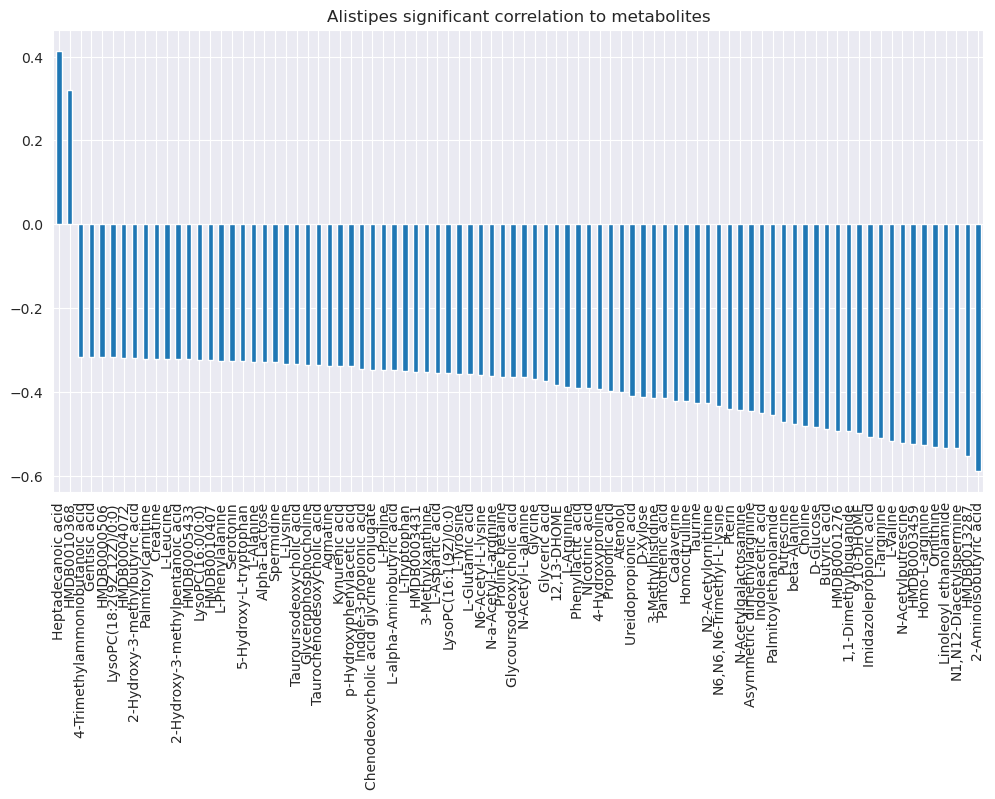

In [53]:
top_bacteria = metabolome_bacteria_significant_corr.groupby(axis=0, level=1).apply(lambda x: x.shape[0]).idxmax()
metabolome_bacteria_significant_corr.loc[idx[:, top_bacteria]].sort_values(ascending=False).plot.bar(figsize=(12,6), title=f'{top_bacteria} significant correlation to metabolites')


In [54]:
metabolites_feces_from_microbial_origin_hmdb = pd.read_csv('/home/noa/lab_code/H2Mtranslation/data/metabolites_feces_from_microbial_origin_hmdb')
metabolites_feces_from_microbial_origin_hmdb = metabolites_feces_from_microbial_origin_hmdb.set_index('HMDB_ID')['NAME']

Compare the overlap between the metabolites that we have find as significantly-correlated with microbiome and HMDB list of 117 feces metabolite that origin from microbial.

In [55]:
metabolome_bacteria_significant_corr.index.get_level_values(0).unique().intersection(metabolites_feces_from_microbial_origin_hmdb.unique())

Index(['p-Hydroxyphenylacetic acid', 'Butyric acid', 'Dimethylglycine',
       'Indoleacetic acid', 'Oxoglutaric acid', 'Phenylacetic acid',
       'Propionic acid', 'Succinic acid',
       'Chenodeoxycholic acid glycine conjugate',
       'Lithocholic acid glycine conjugate', 'Glycoursodeoxycholic acid',
       'Hydrocinnamic acid', 'Nonadecanoic acid', 'Phenyllactic acid',
       'Taurodeoxycholic acid', 'Trimethylamine N-oxide',
       'Taurochenodesoxycholic acid', 'Putrescine', 'N-Acetylputrescine',
       'Indole-3-propionic acid', 'Cadaverine', 'D-Glutamic acid',
       'Phenylacetylglutamine'],
      dtype='object')

In [56]:
metabolome_bacteria_significant_corr.index.get_level_values(0).unique().intersection(metabolites_feces_from_microbial_origin_hmdb.unique()).shape[0]

23

How many of the feces metabolite that origin from microbial (HMDB list) are in our datasets (with enough data?)

In [57]:
metabolite.columns.intersection(metabolites_feces_from_microbial_origin_hmdb.unique()).shape[0]

28

In [58]:
23/28

0.8214285714285714

So we identified 23/28 (82%) as associate to microbiome, (overall to 75% of the 375 metabolite we measure have correlation. 
How is it relative to randomly sampling 28 metabolite out of the 375 with significant tag?) 

How the relationship look like on the 5 that we didn't identify as microbiome driven? 
How this 23 look like with respect to the rest? 
How many unknown/known metabolite do I have in this list?  


In [59]:
# sample 28 out of 375 only with the tag significant/not. And calculate the groups % of positive. 
is_metabolite_correlates = pd.Series(metabolite.columns, index=metabolite.columns).apply(lambda x: x in metabolome_bacteria_significant_corr.index.get_level_values(0).unique())
is_metabolite_correlates

Deoxycytidine                  True
4-Pyridoxic acid              False
alpha-Ketoisovaleric acid      True
p-Hydroxyphenylacetic acid     True
Ureidopropionic acid           True
                              ...  
HMDB0042093                   False
HMDB0043058                    True
2-Hydroxyglutarate            False
HMDB0059824                    True
10Z-Heptadecenoic acid         True
Length: 375, dtype: bool

In [60]:
exp_ = [round(is_metabolite_correlates.sample(n=28).mean() * 100, 2) for _ in range(1000)]

In [61]:
pd.Series(exp_).describe()

count    1000.000000
mean       75.685280
std         7.720089
min        50.000000
25%        71.430000
50%        75.000000
75%        82.140000
max        96.430000
dtype: float64

What do we know on the 23 metabolites (fecal from microbial origin according to HMDB) #TODO

In [62]:
import re
taxa_genus = taxa.rename(columns=lambda x: re.match('.*g__(.*)', x).group(1))

In [63]:
metabolome_bacteria_p_values_fdr_correction = metabolome_bacteria_p_values_fdr_correction.rename(taxa_rename_to_genus.to_dict(), axis=0, level=1)

sanity checks - for some significant correlation between microbiome-metabolome plot the relation across the samples 
see how much I believe this correlation analysis & how much it's effected by outliers. 

<Axes: title={'center': 'corr coef=0.53, p-value=2.46e-05'}, xlabel='Coprococcus', ylabel='Sorbitol'>

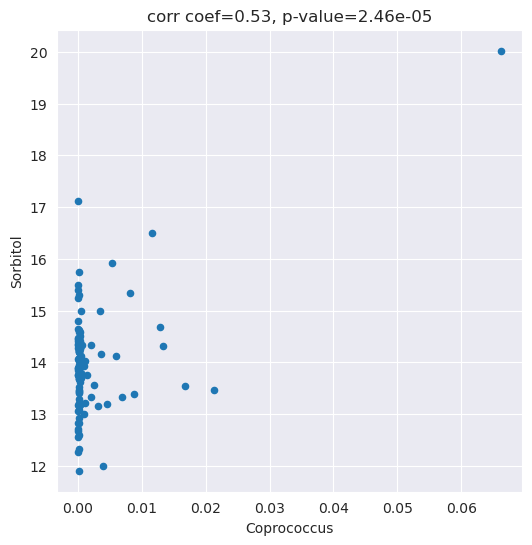

In [64]:
metabolite_1, microbiome_1 = metabolome_bacteria_significant_corr.sort_values(ascending=False).index[0]
pd.concat([metabolite[metabolite_1], taxa_genus[microbiome_1]], axis=1).plot.scatter(x=microbiome_1, y=metabolite_1, figsize=(6,6), 
                                                                                     title = f'corr coef={round(metabolome_bacteria_significant_corr[(metabolite_1, microbiome_1)],2)}, p-value={"{:.2e}".format(metabolome_bacteria_p_values_fdr_correction[(metabolite_1, microbiome_1)])}')

In [65]:
metabolite[metabolite_1][metabolite[metabolite_1] > 18].index[0]

'MSM6J2M3'

<Axes: title={'center': 'corr coef=0.09, p-value=3.53e-01'}, xlabel='Coprococcus', ylabel='Sorbitol'>

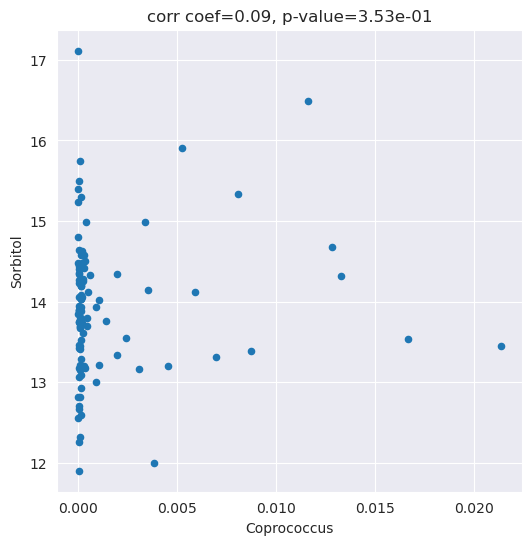

In [66]:
coefficient, p  = stats.pearsonr(metabolite[metabolite_1].drop('MSM6J2M3'), taxa_genus[microbiome_1].drop('MSM6J2M3'))
pd.concat([metabolite[metabolite_1].drop('MSM6J2M3'), taxa_genus[microbiome_1].drop('MSM6J2M3')], axis=1).plot.scatter(x=microbiome_1, y=metabolite_1, figsize=(6,6), 
                                                                                     title = f'corr coef={round(coefficient,2)}, p-value={"{:.2e}".format(p)}')

<Axes: title={'center': 'corr coef=0.51, p-value=5.57e-05'}, xlabel='Catenibacterium', ylabel='Mandelic acid'>

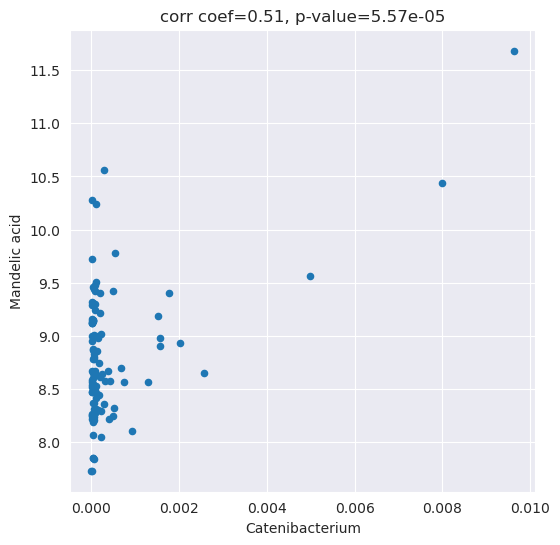

In [67]:
metabolite_1, microbiome_1 = metabolome_bacteria_significant_corr.sort_values(ascending=False).index[2]
pd.concat([metabolite[metabolite_1], taxa_genus[microbiome_1]], axis=1).plot.scatter(x=microbiome_1, y=metabolite_1, figsize=(6,6), 
                                                                                     title = f'corr coef={round(metabolome_bacteria_significant_corr[(metabolite_1, microbiome_1)],2)}, p-value={"{:.2e}".format(metabolome_bacteria_p_values_fdr_correction[(metabolite_1, microbiome_1)])}')

In [68]:
outliers = taxa_genus[microbiome_1][taxa_genus[microbiome_1] > 0.006].index.to_list()


In [69]:
outliers

['HSMA33NY', 'HSMA33J9']

<Axes: title={'center': 'corr coef=0.15, p-value=1.29e-01'}, xlabel='Catenibacterium', ylabel='Mandelic acid'>

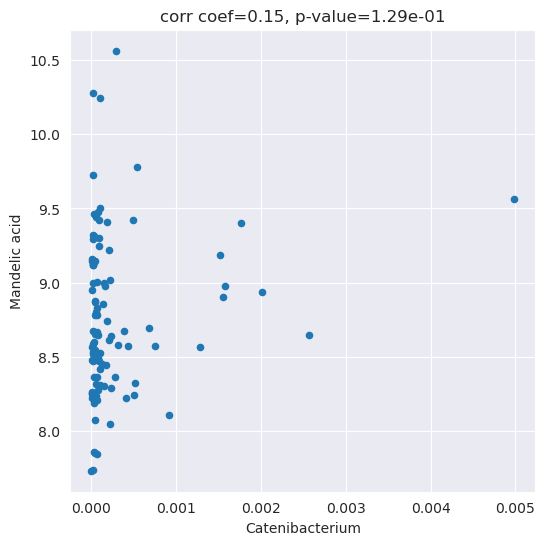

In [70]:
# outliers = metabolite[metabolite_1][metabolite[metabolite_1] < 12].index.to_list()
coefficient, p  = stats.pearsonr(metabolite[metabolite_1].drop(outliers), taxa_genus[microbiome_1].drop(outliers))
pd.concat([metabolite[metabolite_1].drop(outliers), taxa_genus[microbiome_1].drop(outliers)], axis=1).plot.scatter(x=microbiome_1, y=metabolite_1, figsize=(6,6), 
                                                                                     title = f'corr coef={round(coefficient,2)}, p-value={"{:.2e}".format(p)}')

In [71]:
# metabolome_bacteria_corr_coefficient 
# metabolome_bacteria_p_values_fdr_correction

In [72]:
#  For unknown (without a name, and known) taxa, plot a scatter plot of the correlations to see if it’s due to some outliers or do I believe it. (metabolite vs. taxa across the 90 samples + in the title mention the correlation coefficient) 

# Plot also metabolite vs. taxa across the 90 samples of metabolite that are known to be microbial origin (the 5 I didn't got as significant)? what does it even mean? read a bit more?

# The most interest question I think is why I didn't get the other 5 microbial origin metabolite as metabolite with correlation to microbiota?
metabolites_group = metabolite.columns.intersection(metabolites_feces_from_microbial_origin_hmdb.unique()).difference(metabolome_bacteria_significant_corr.index.get_level_values(0))
print(metabolites_group)

Index(['2-Hydroxyglutarate', 'Deoxycholic acid glycine conjugate',
       'Glycocholic acid', 'Hippuric acid', 'Oxalic acid'],
      dtype='object')


In [73]:
hmdb_metadata.query('name in @metabolites_group').set_index('name')['description'].iloc[0]

'Glycocholic acid is an acyl glycine and a bile acid-glycine conjugate. It is a secondary bile acid produced by the action of enzymes existing in the microbial flora of the colonic environment.  Bacteroides, Bifidobacterium, Clostridium and Lactobacillus are involved in bile acid metabolism and produce glycocholic acid (PMID: 6265737; 10629797). In hepatocytes, both primary and secondary bile acids undergo amino acid conjugation at the C-24 carboxylic acid on the side chain, and almost all bile acids in the bile duct therefore exist in a glycine conjugated form (PMID: 16949895). More specifically, glycocholic acid or cholylglycine, is a crystalline bile acid involved in the emulsification of fats. It occurs as a sodium salt in the bile of mammals. Its anion is called glycocholate. As the glycine conjugate of cholic acid, this compound acts as a detergent to solubilize fats for absorption and is itself absorbed (PubChem). Bile acids are steroid acids found predominantly in bile of mamma

<Axes: ylabel='Frequency'>

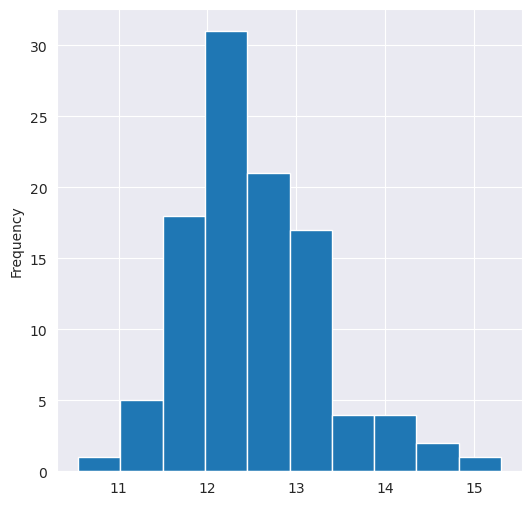

In [74]:
metabolite['2-Hydroxyglutarate'].plot.hist(figsize=(6,6))

In [75]:
# before grouping by and other pre-processing:
# 
# metabolite_org = pd.read_csv(f'{human_db_path}/{dataset}/mtb.tsv' ,sep='\t')
# metabolite_org = metabolite_org[metabolite_org.Sample.isin(control_samples_ids)]
# metabolite_org = metabolite_org.set_index('Sample')
# metabolite_org = metabolite_org[metabolite_org.columns.intersection(metabolite_to_hmdb.dropna().index)].rename(columns=metabolite_to_hmdb.dropna())
# metabolite_org = metabolite_org.rename(columns=map_hmdb_id_to_name)


In [76]:
# metabolite_org[metabolites_group]

Top 5 bacteria (that correlates with a lot of metabolites):  

In [77]:
metabolome_bacteria_significant_corr.groupby(axis=0, level=1).apply(lambda x: x.shape[0]).sort_values(ascending=False).iloc[:5].index.to_list()

['Alistipes', 'Scatosoma', 'Faecousia', 'Dysosmobacter', 'Clostridium_A']

Internet: 
Alistipes - Gram-negative genus in the phylum Bacteridota. Highly associated with our health. 
 https://en.wikipedia.org/wiki/Alistipes
 https://www.sciencedirect.com/topics/immunology-and-microbiology/alistipes
 https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2020.00906/full
 Indeed involve in a lot of pathways:
https://www.genome.jp/kegg-bin/show_organism?menu_type=pathway_maps&category=Alistipes


Our data: 
* per bacteria, show the relative-abundance across the 90 samples. (distribution)

<Axes: title={'center': 'Alistipes'}, ylabel='Frequency'>

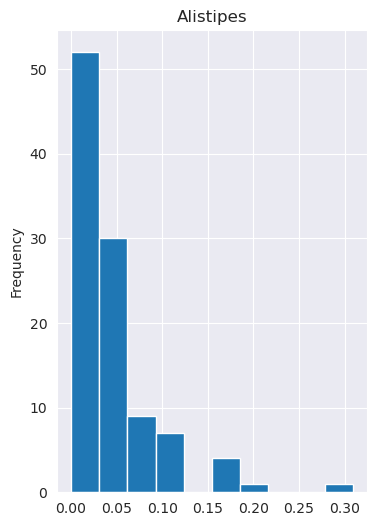

In [78]:
taxa_genus['Alistipes'].plot.hist(figsize=(4,6), title='Alistipes')

In [79]:
taxa_genus['Alistipes'].describe()

count    104.000000
mean       0.041993
std        0.048553
min        0.000044
25%        0.007175
50%        0.030394
75%        0.056471
max        0.309247
Name: Alistipes, dtype: float64

In [80]:
# TODO: How much the result changes/ how does they look like when I consider sperman/ kendall correlation? 

[Text(0.5, 1.0, 'Heatmap significant or not correlation of Metabolite & Bacteria')]

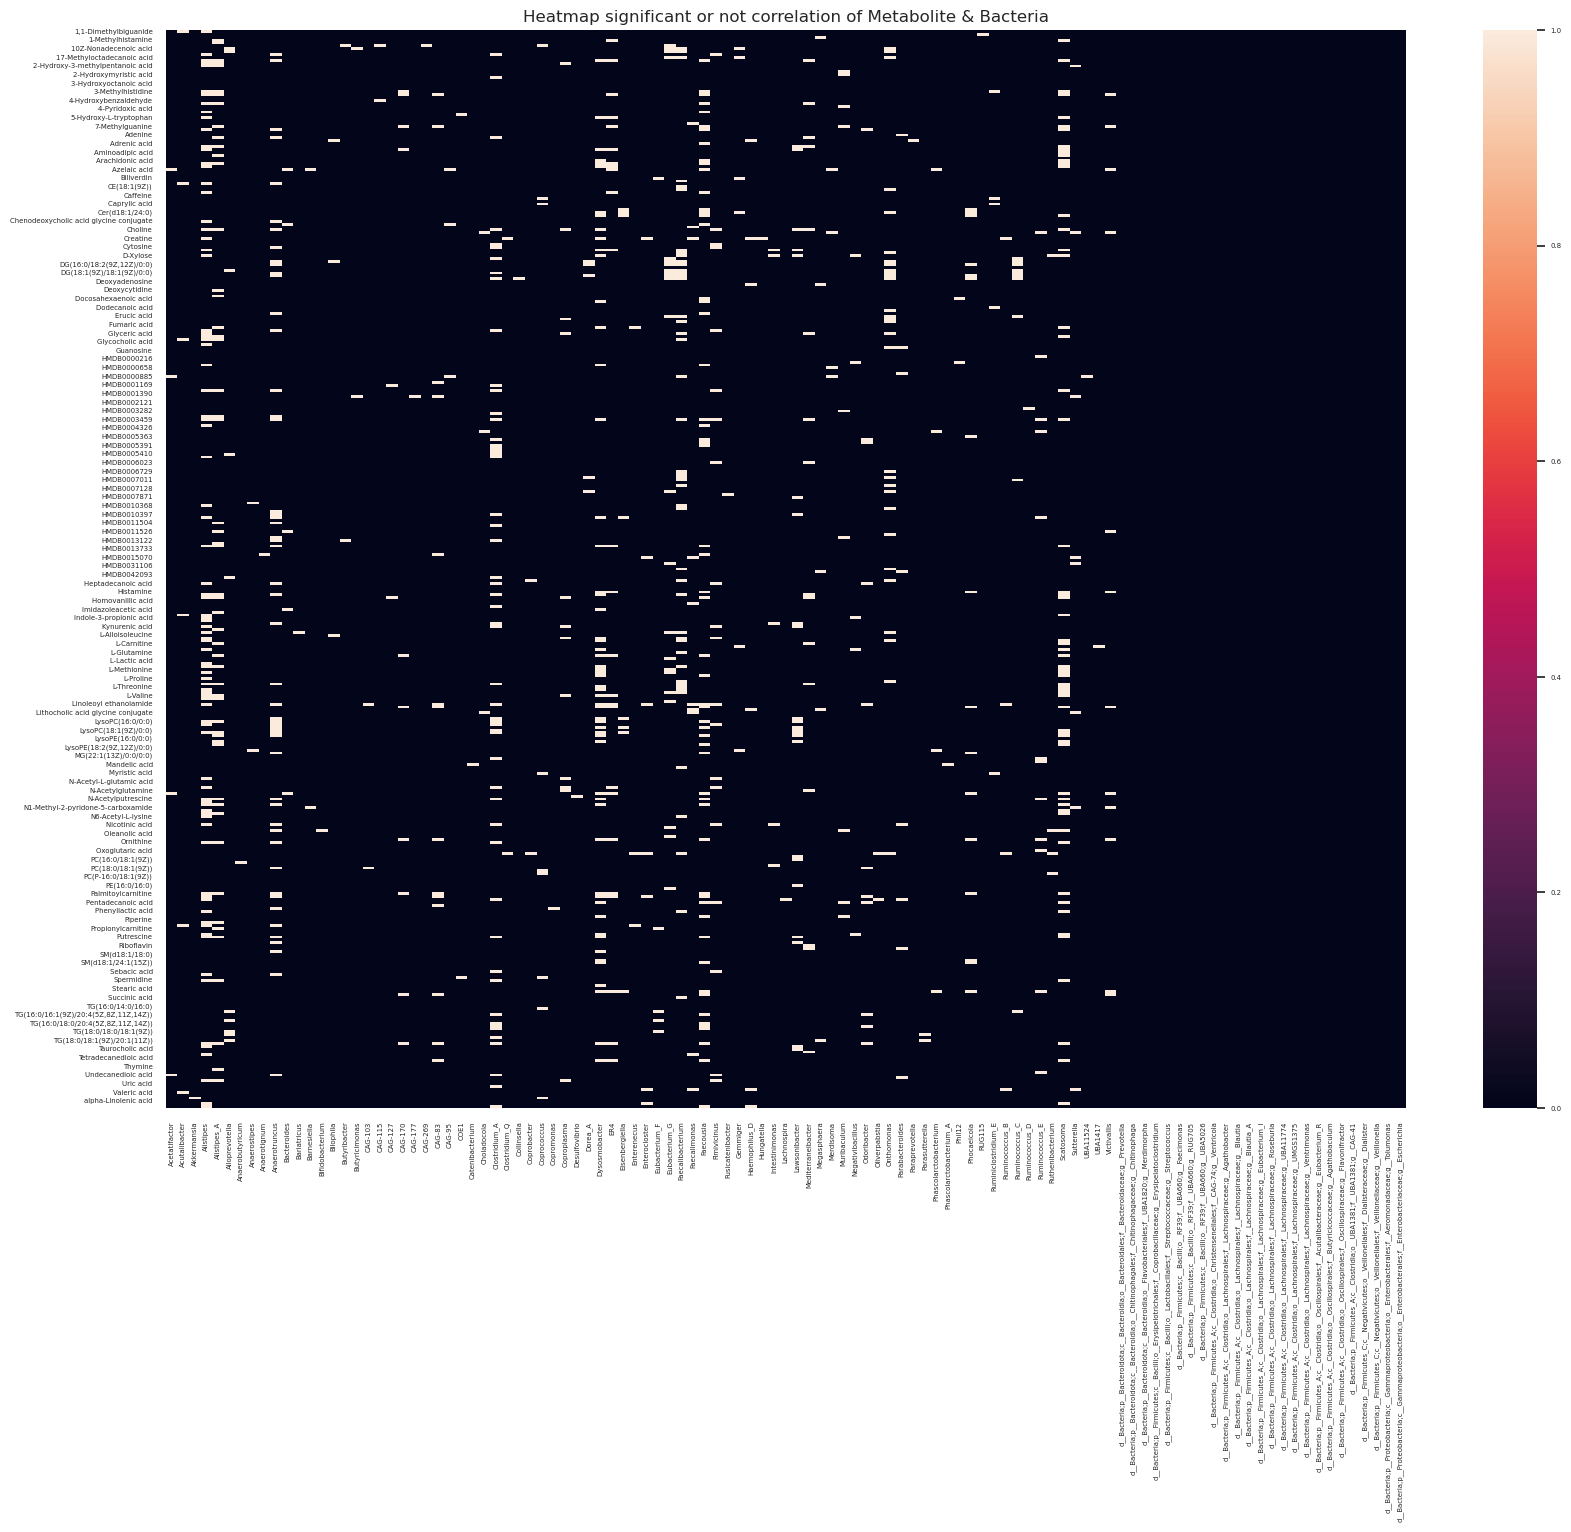

In [81]:
sns.set_theme(rc={'figure.figsize':(20,14), 'xtick.labelsize':5, 'ytick.labelsize':5})
sns.heatmap((metabolome_bacteria_p_values_fdr_correction.unstack() < 0.05).astype(int)).set(title='Heatmap significant or not correlation of Metabolite & Bacteria')

[Text(0.5, 1.0, 'Heatmap significant correlation of Metabolite & Bacteria')]

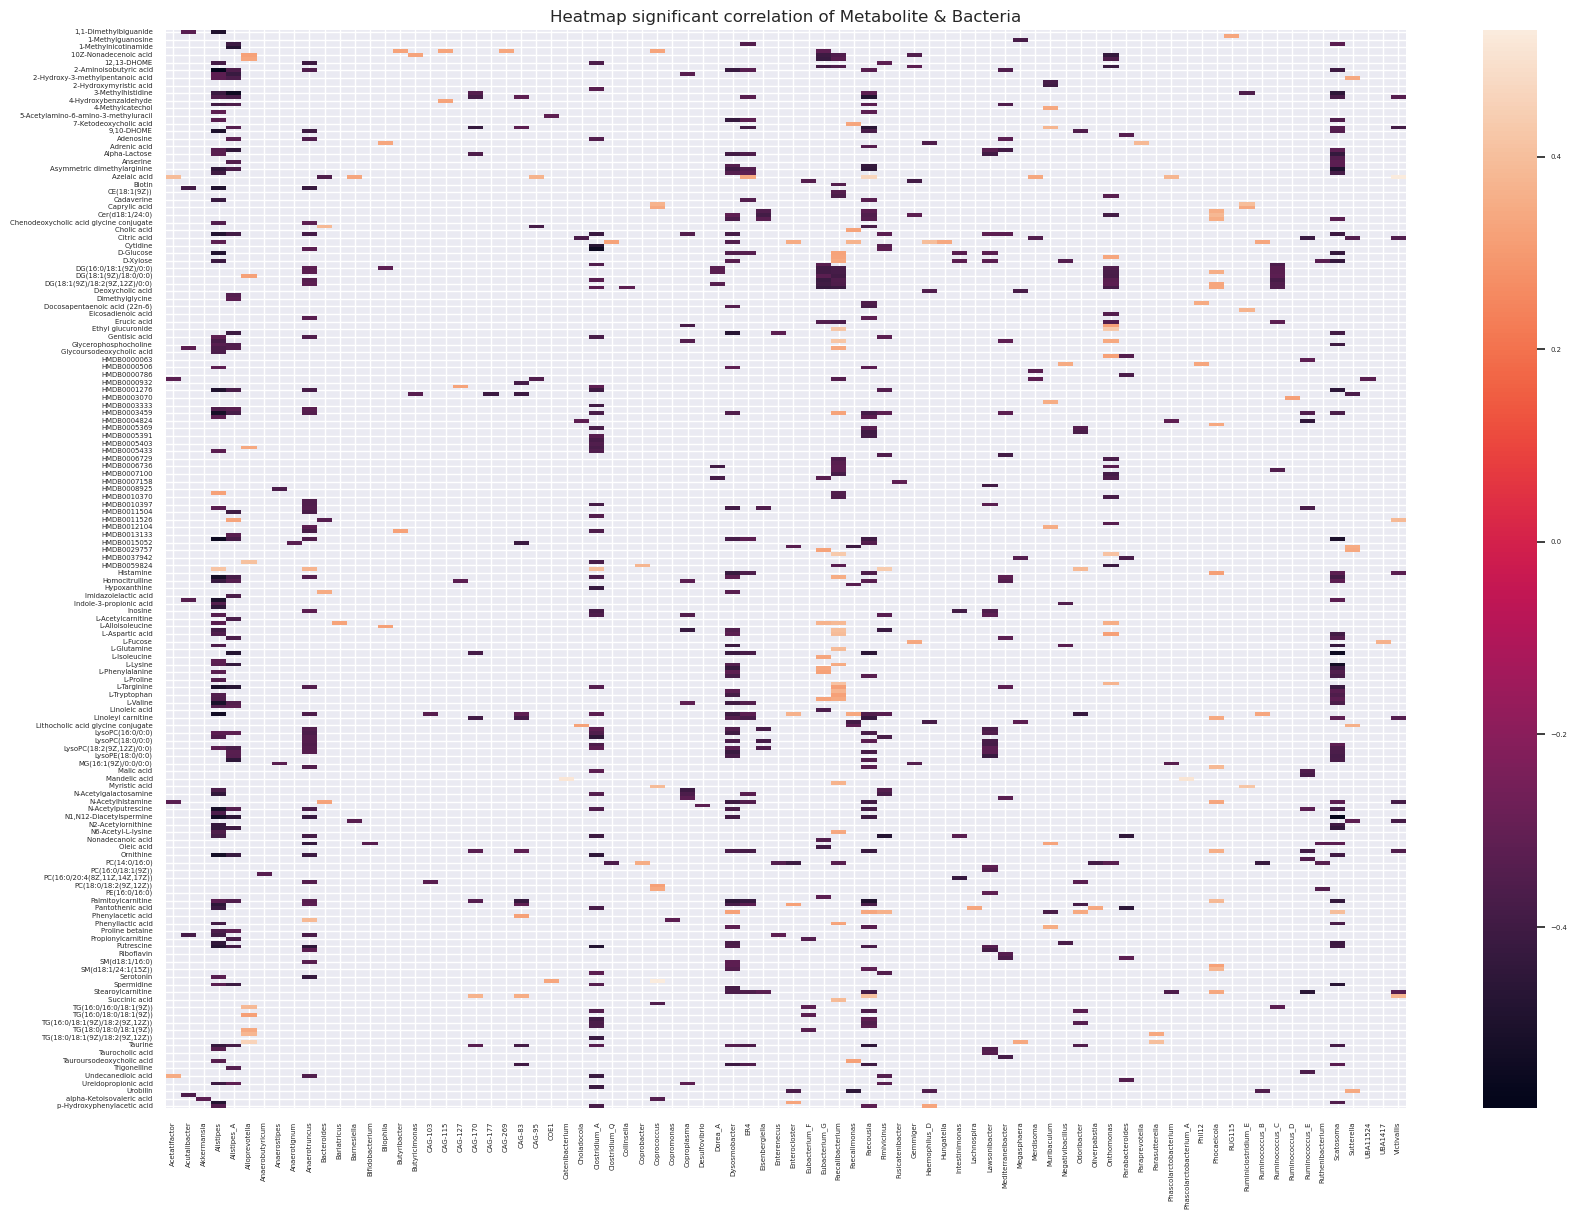

In [82]:
sns.heatmap(metabolome_bacteria_significant_corr.unstack().astype(float)).set(title='Heatmap significant correlation of Metabolite & Bacteria')
